## organize data for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plot_helper import accuracy_plot, relation_plot

version = 'v20251125'
targets = ['SOCconc', 'CF', 'BD', 'SOCdensity']
models = ['MultiNN', 'SiNN']
# models = ['UniNN','MultiNN','SiNN']

df = pd.read_parquet(f'./data/all_cv.pred_with.lc.pq')
# # read in
# mlt = pd.read_csv(f'./eval/02_multiNN_cv.pred_{version}.csv')
# print("MultiNN:", mlt.shape)
# hbd = pd.read_csv(f'./eval/03_hybridNN_cv.pred_{version}.csv')
# print("HybridNN:", hbd.shape)

# # rename relevant cols
# name_map = {"ndvi_glad_landast_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231127":"ndvi",
#             "ndwi_gao_glad_landsat_ard2_seasconv_m_yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg_3035_v20231218":"ndwi",
#             "clm_lst_mod11a2_nighttime_p50_1km_s0_0cm_YYYY_v1_2":"lst_night",
#             "clm_lst_mod11a2_daytime_p50_1km_s0_0cm_YYYY_v1_2":"lst_day",
#             "clm_accum_precipitation_chelsa_annual_m_1km_s0_0cm_YYYY_v2_1":"precipitation",
#             "peatland_extent_wri_gfw_peatgrids_p_1km_s_2000_2020_go_epsg4326_v20241017":"peat"}
# mlt = mlt.rename(columns=name_map)

# # get and rename pred cols
# mlt = mlt[['row_id', 'time', 'lat', 'lon', 'id', 'nuts0', 'maxdiff', 
#        'bd','clay', 'sand', 'silt', 'cf', 'ocd', 'soc',
#        'SOCconc', 'CF', 'BD', 'SOCdensity', 
#        'pred_BD', 'pred_SOCconc', 'pred_CF', 'pred_SOCdensity', 
#        'ndvi','ndwi','lst_night','lst_day','precipitation','peat']]
# iid = models[0]
# kmap = {}
# for pp in ['pred_BD', 'pred_SOCconc', 'pred_CF', 'pred_SOCdensity']:
#     kmap[pp] = pp.replace('pred',iid)
# mlt = mlt.rename(columns=kmap)


# hbd = hbd[['row_id','pred_BD', 'pred_SOCconc','pred_CF', 'pred_SOCdensity', 'pred_oBD', 'pred_mBD']]
# iid = models[1]
# kmap = {}
# for pp in ['pred_BD', 'pred_SOCconc', 'pred_CF', 'pred_SOCdensity']:
#     kmap[pp] = pp.replace('pred',iid)
# hbd = hbd.rename(columns=kmap)

# # join prediction results
# df = mlt.merge(hbd, on="row_id", how="left")
# print(df.shape)

# # ### get land cover
# mm = []
# for tt in ['2009','2012','2015','2018']:
#     mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUCAS_TOPSOIL/lucas_microdata/EU_{tt}_20200213.CSV')
#     mmt['time'] = int(tt)
#     mm.append(mmt[['POINT_ID', 'LC1', 'time']])
    
# mm = pd.concat(mm)
# mm['POINT_ID'] = pd.to_numeric(mm['POINT_ID'], errors='coerce')
# mm = mm.dropna(subset=['POINT_ID'])
# mm['POINT_ID'] = mm['POINT_ID'].astype(int)
# mm = mm.rename(columns={'POINT_ID': 'id'})
# merged = df.merge(mm, on=['id', 'time'], how='left')
# merged['LC_group'] = merged['LC1'].str[0]  # Extract first letter

# survey_dict = {
#     "A": "artificial",
#     "B": "cropland",
#     "C": "woodland",
#     "D": "shrubland",
#     "E": "grassland",
#     "F": "bareland", # bareland and lichen and mosses
#     "G": "wetland", # water areas
#     "H": "wetland",  # wetlands
# }

# # Map land cover codes to descriptions
# merged['LC_group'] = merged['LC_group'].map(survey_dict)

# print(merged.shape)
# merged.to_parquet(f'./data/all_cv.pred_with.lc.pq')

## accuracy analysis

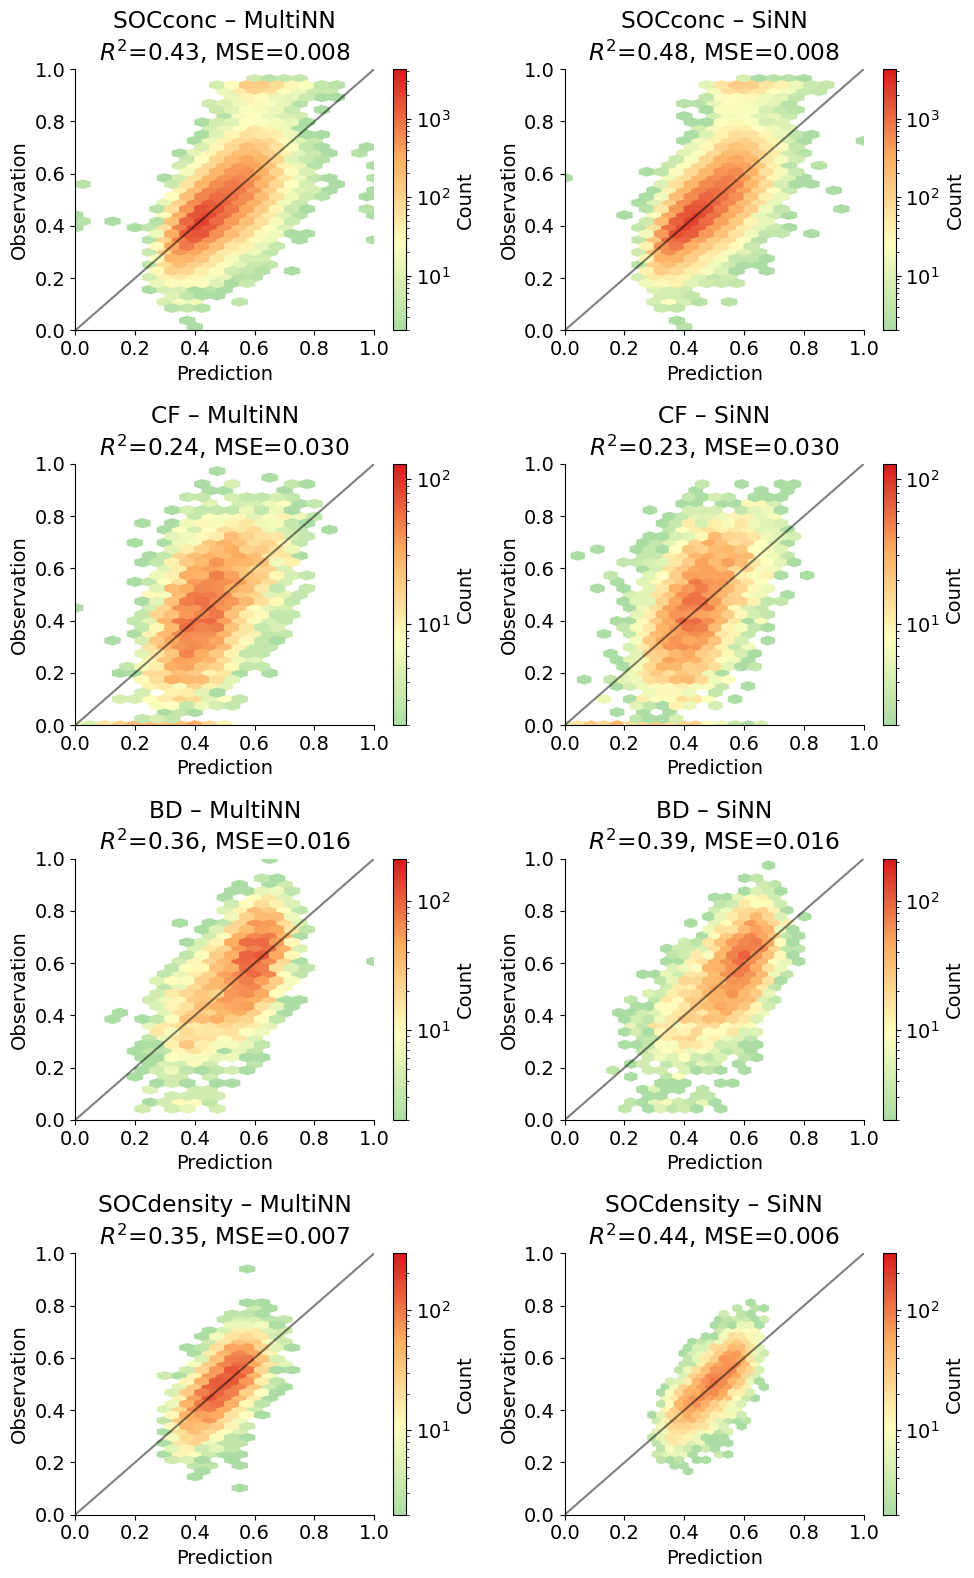

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
cet_l19_cmap = LinearSegmentedColormap.from_list("CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"])
plt.rcParams.update({'font.size': 14})

targets = ['SOCconc', 'CF', 'BD', 'SOCdensity']
models = ['MultiNN', 'SiNN']
gridsize = (20, 20)

# Create one figure with a 4×2 grid
fig, axes = plt.subplots(
    nrows=len(targets),
    ncols=len(models),
    figsize=(10, 16),
    sharex=False,
    sharey=False
)

def compute_r2_mse(y_true, y_pred):
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_t = y_true[mask]
    y_p = y_pred[mask]
    if y_t.size == 0:
        return np.nan, np.nan
    mse = np.mean((y_t - y_p) ** 2)
    denom = np.sum((y_t - y_t.mean()) ** 2)
    r2 = np.nan if denom == 0 else 1 - np.sum((y_t - y_p) ** 2) / denom
    return r2, mse

for i, tgt in enumerate(targets):

    # ---- compute row-level vmax ----
    row_vals = []
    for mod in models:
        y_true = df[tgt].values
        y_pred = df[f"{mod}_{tgt}"].values
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        row_vals.append(np.column_stack([y_pred[mask], y_true[mask]]))

    row_vals = np.vstack(row_vals)
    vmin = row_vals.min()
    vmax = row_vals.max()

    # reference hexbin for vmax of counts
    dummy_fig, dummy_ax = plt.subplots()
    hb_ref = dummy_ax.hexbin(
        row_vals[:, 0], row_vals[:, 1],
        gridsize=gridsize, bins="log", mincnt=2
    )
    row_count_vmax = hb_ref.get_array().max()
    plt.close(dummy_fig)

    # ---- actual subplots in this row ----
    for j, mod in enumerate(models):

        ax = axes[i, j]   # <-- use the pre-created grid

        y_true = df[tgt].values
        y_pred = df[f"{mod}_{tgt}"].values
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        y_t = y_true[mask]
        y_p = y_pred[mask]

        hb = ax.hexbin(
            y_p, y_t,
            gridsize=gridsize,
            cmap=cet_l19_cmap,
            bins="log",
            mincnt=2,
            vmax=row_count_vmax
        )

        ax.plot([vmin, vmax], [vmin, vmax], "-k", alpha=0.5)
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)

        r2, mse = compute_r2_mse(y_true, y_pred)

        ax.set_title(f"{tgt} – {mod}\n$R^2$={r2:.2f}, MSE={mse:.3f}")
        ax.set_xlabel("Prediction")
        ax.set_ylabel("Observation")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Add colorbar for each subplot
        cbar = fig.colorbar(hb, ax=ax)
        cbar.set_label("Count")

plt.tight_layout()
plt.show()

## joint distribution between BD and SOCconc

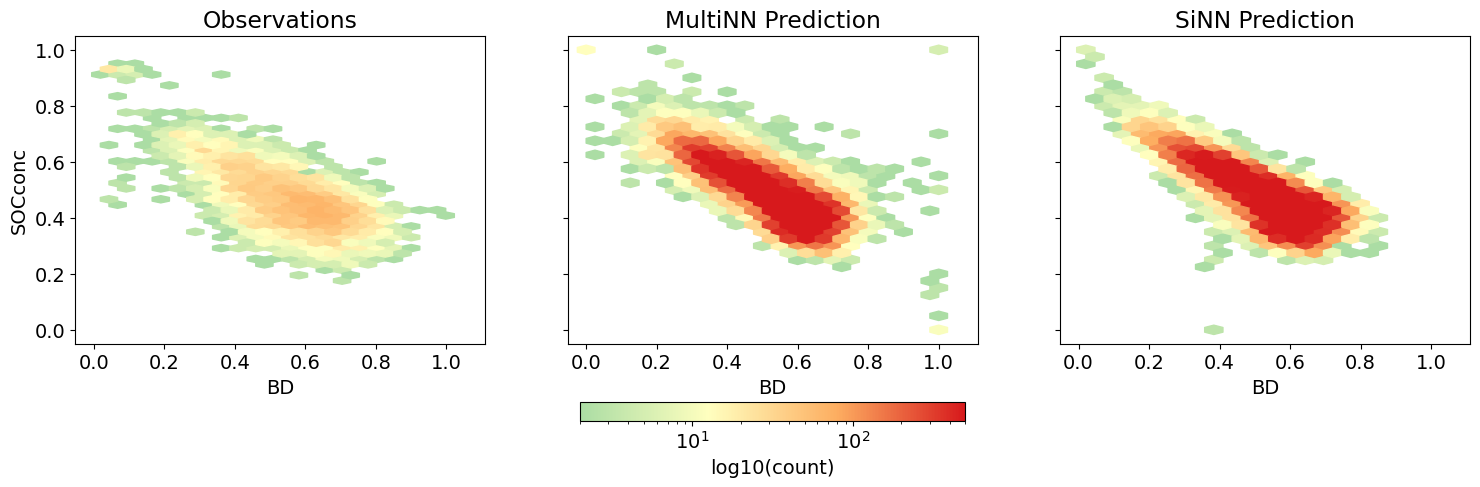

In [21]:
row_count_vmax = 500

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# --- 1. Observations ---
hb0 = axes[0].hexbin(
    df['BD'], df['SOCconc'],
    gridsize=gridsize,
    cmap=cet_l19_cmap,
    bins="log",
    mincnt=2,
    vmax=row_count_vmax
)
axes[0].set_title("Observations")
axes[0].set_xlabel("BD")
axes[0].set_ylabel("SOCconc")

# --- 2. MultiNN Predictions ---
hb1 = axes[1].hexbin(
    df['MultiNN_BD'], df['MultiNN_SOCconc'],
    gridsize=gridsize,
    cmap=cet_l19_cmap,
    bins="log",
    mincnt=2,
    vmax=row_count_vmax
)
axes[1].set_title("MultiNN Prediction")
axes[1].set_xlabel("BD")

# --- 3. SiNN Predictions ---
hb2 = axes[2].hexbin(
    df['SiNN_BD'], df['SiNN_SOCconc'],
    gridsize=gridsize,
    cmap=cet_l19_cmap,
    bins="log",
    mincnt=2,
    vmax=row_count_vmax
)
axes[2].set_title("SiNN Prediction")
axes[2].set_xlabel("BD")

# --- Bottom colorbar ---
# plt.subplots_adjust(bottom=0.1)
cbar = fig.colorbar(
    hb2,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    fraction=0.05,
    pad=0.15
)
cbar.set_label("log10(count)")

# plt.tight_layout()
plt.show()


## temporal stability of the prediction

In [40]:
df.loc[df['SiNN_SOCdensity']<0]

,row_id,time,lat,lon,id,nuts0,maxdiff,bd,clay,sand,...,precipitation,peat,SiNN_BD,SiNN_SOCconc,SiNN_CF,SiNN_SOCdensity,pred_oBD,pred_mBD,LC1,LC_group
8152,40659,2018,50.448899,15.482401,47103052,CZ,0.4,NaN,24.0,9.0,...,-0.702051,-0.270777,0.396750,2.824151e-23,0.000000,-inf,0.050000,0.750000,C10,woodland
18106,34553,2015,48.448590,18.820600,49722854,SK,29.9,NaN,13.0,47.0,...,0.270083,-0.270777,0.396686,1.018265e-03,0.116233,-0.883300,0.050053,0.750001,C31,woodland
24412,9578,2009,48.745310,10.040800,43242848,DE,-1.0,NaN,22.0,13.0,...,0.791471,-0.270777,1.058000,0.000000e+00,0.000000,-inf,0.050000,2.000000,C30,woodland
55601,53503,2018,37.965023,-7.374071,27981828,PT,6.4,NaN,24.0,51.0,...,0.283539,-0.270777,0.404916,7.268400e-02,0.400629,-0.131043,0.091568,0.771495,E20,grassland
56000,55549,2018,48.448600,18.820614,49722854,SK,29.9,NaN,13.0,47.0,...,-0.237849,-0.270777,0.396687,9.966390e-04,0.117977,-0.886914,0.050053,0.750001,C31,woodland


In [33]:

df_filtered = df.copy()

# Columns to analyse
vars_to_check = ["MultiNN_SOCdensity", "SiNN_SOCdensity"]

# ---- 1. COUNT IDS BY NUMBER OF TIME POINTS ----
id_counts = df_filtered['id'].value_counts()

num_ids_all3 = (id_counts == 3).sum()
num_ids_not3 = (id_counts != 3).sum()

print("IDs with all 3 time points:", num_ids_all3)
print("IDs WITHOUT all 3 time points:", num_ids_not3)

# ---- 2. KEEP ONLY IDS THAT HAVE ALL 3 ROWS ----
valid_ids = id_counts[id_counts == 3].index
df3 = df_filtered[df_filtered['id'].isin(valid_ids)]

print("Filtered dataframe shape:", df3.shape)

# ---- 3. TEMPORAL STABILITY USING IQR AND RANGE ----
stability = (
    df3.groupby("id")[vars_to_check]
       .agg(['min', 'max', lambda x: np.min(x) - np.max(x)])
)

# rename columns
stability.columns = [f"{var}_{stat}"
                     for var, stat in stability.columns]
stability = stability.reset_index()

# Compute range
for var in vars_to_check:
    stability[f"{var}_range"] = stability[f"{var}_max"] - stability[f"{var}_min"]



IDs with all 3 time points: 11690
IDs WITHOUT all 3 time points: 13738
Filtered dataframe shape: (35070, 36)


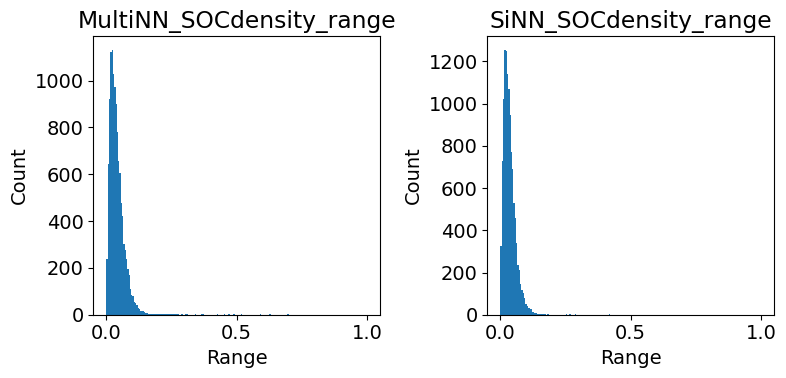

In [34]:

# Corresponding range columns
range_cols = [f"{v}_range" for v in vars_to_check]

plt.figure(figsize=(12, 4))

for i, col in enumerate(range_cols):
    plt.subplot(1, 3, i+1)
    plt.hist(stability[col].dropna(), range=[0,1], bins=200)
    plt.title(col)
    plt.xlabel("Range")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


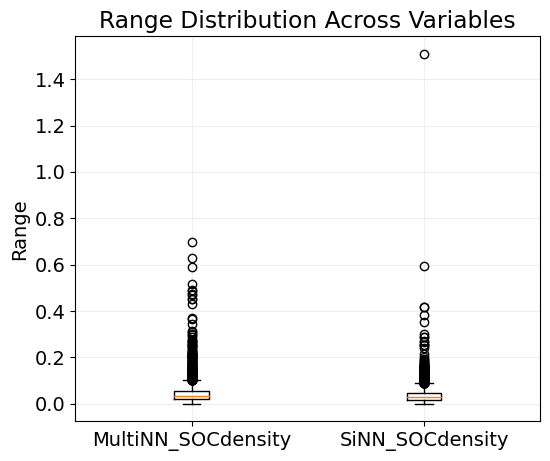

In [37]:
plt.figure(figsize=(6,5))

plt.boxplot(
    [stability[f"{v}_range"].dropna() for v in vars_to_check],
    labels=vars_to_check,
    showfliers=True
)

plt.ylabel("Range")
plt.title("Range Distribution Across Variables")
plt.grid(alpha=0.2)
plt.show()


/tmp/ipykernel_21668/3072470465.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


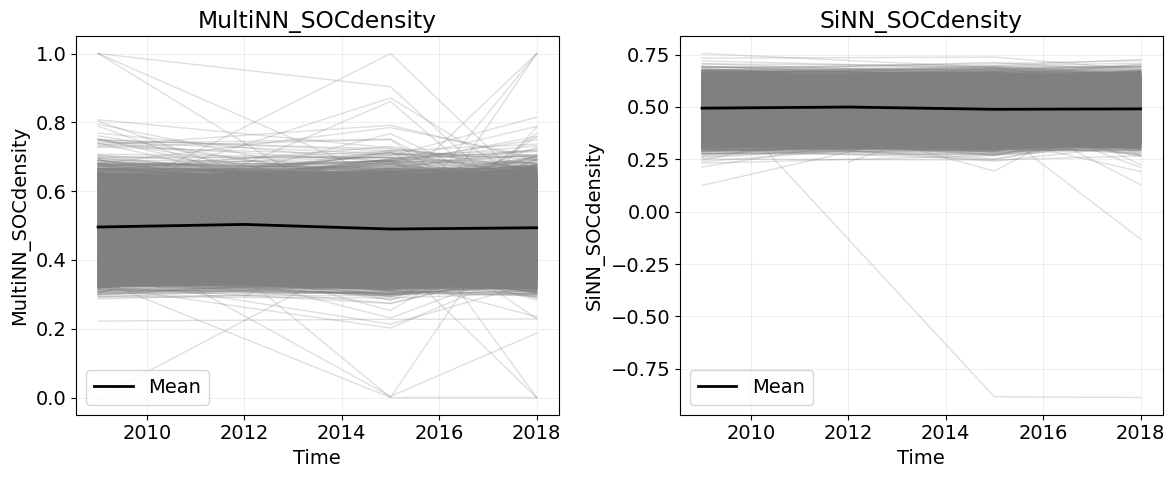

In [36]:
plt.figure(figsize=(12,5))

for idx, var in enumerate(vars_to_check, 1):

    plt.subplot(1, 2, idx)

    # --- plot all individual time series ---
    for gid, gdf in df3.groupby("id"):
        gdf_sorted = gdf.sort_values("time")
        plt.plot(gdf_sorted["time"], gdf_sorted[var],
                 color="gray", alpha=0.25, linewidth=1)

    # --- compute mean and plot ---
    mean_df = df3.groupby("time")[var].mean().reset_index()
    plt.plot(mean_df["time"], mean_df[var],
             color="black", linewidth=2, label="Mean")

    plt.title(var)
    plt.xlabel("Time")
    plt.ylabel(var)
    plt.grid(True, alpha=0.2)
    plt.legend()

plt.tight_layout()
plt.show()


In [15]:


do = df.copy()

# 

# df = pd.read_parquet(f'./data/{testid}_cv.pred_with.lc.pq')

# print(df.shape)
# target_names = ['SOCconc','CF','BD','SOCdensity']

# scalers = {'SOCconc':0.151,'CF':0.263,'BD':0.529,'SOCdensity':0.167} # current
# # scalers = {'SOCconc':0.158,'CF':2.2,'BD':0.52,'SOCdensity':0.165} # old problematic

# for tgt in target_names:
#     df[tgt] = df[tgt]/scalers.get(tgt)
#     df[f'pred_{tgt}'] = df[f'pred_{tgt}']/scalers.get(tgt)
#     if tgt in ['SOCconc','CF']:
#         df[tgt] = np.expm1(df[tgt])
#         df[f'pred_{tgt}'] = np.expm1(df[f'pred_{tgt}'])
#     elif tgt=='SOCdensity':
#         df[tgt] = np.exp(df[tgt])
#         df[f'pred_{tgt}'] = np.exp(df[f'pred_{tgt}'])
        
        
#     # plt.figure()  # Create a new figure for each target
#     # plt.hist(df[tgt], bins=20, edgecolor='black')
#     # # plt.title(f"Histogram of {tgt}, {mm:.3f}")
#     # plt.xlabel(tgt)
#     # plt.ylabel("Frequency")
#     # plt.show()

# for tgt in target_names:
#     if tgt in ['SOCconc','CF']:
#         yv = np.log1p(do[tgt].dropna())
#     elif tgt=='SOCdensity':
#         yv = np.log(do[tgt].dropna())
#     else:
#         yv = do[tgt].dropna()
        
#     plt.figure()  # Create a new figure for each target
#     mm = np.max(yv)
#     ss = 1/mm
#     sc = scalers.get(tgt)
#     print(np.max(yv*sc), sc)
#     plt.hist(yv*sc, bins=20, edgecolor='black')
#     plt.title(f"Histogram of {tgt}, {mm:.3f}")
#     plt.xlabel(tgt)
#     plt.ylabel("Frequency")
#     plt.show()



# for tgt in target_names:
#     df[f'error_{tgt}'] = df[f'pred_{tgt}'] - df[tgt]

/tmp/ipykernel_21294/48202305.py:5: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUCAS_TOPSOIL/lucas_microdata/EU_{tt}_20200213.CSV')
/tmp/ipykernel_21294/48202305.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUCAS_TOPSOIL/lucas_microdata/EU_{tt}_20200213.CSV')
/tmp/ipykernel_21294/48202305.py:5: DtypeWarning: Columns (0,21,28) have mixed types. Specify dtype option on import or set low_memory=False.
  mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUCAS_TOPSOIL/lucas_microdata/EU_{tt}_20200213.CSV')
/tmp/ipykernel_21294/48202305.py:5: DtypeWarning: Columns (0,32) have mixed types. Specify dtype option on import or set low_memory=False.
  mmt = pd.read_csv(f'/home/xuemeng/work_xuemeng/soil-data/data_raw/EU/LUC

(56117, 36)


NameError: name 'target_names' is not defined

In [14]:
merged.columns

Index(['row_id', 'time', 'lat', 'lon', 'id', 'nuts0', 'maxdiff', 'bd', 'clay',
       'sand', 'silt', 'cf', 'ocd', 'soc', 'SOCconc', 'CF', 'BD', 'SOCdensity',
       'MultiNN_BD', 'MultiNN_SOCconc', 'MultiNN_CF', 'MultiNN_SOCdensity',
       'ndvi', 'ndwi', 'lst_night', 'lst_day', 'precipitation', 'peat',
       'SiNN_BD', 'SiNN_SOCconc', 'SiNN_CF', 'SiNN_SOCdensity', 'pred_oBD',
       'pred_mBD', 'LC1'],
      dtype='object')

## Accuracy

Worse performance for CV

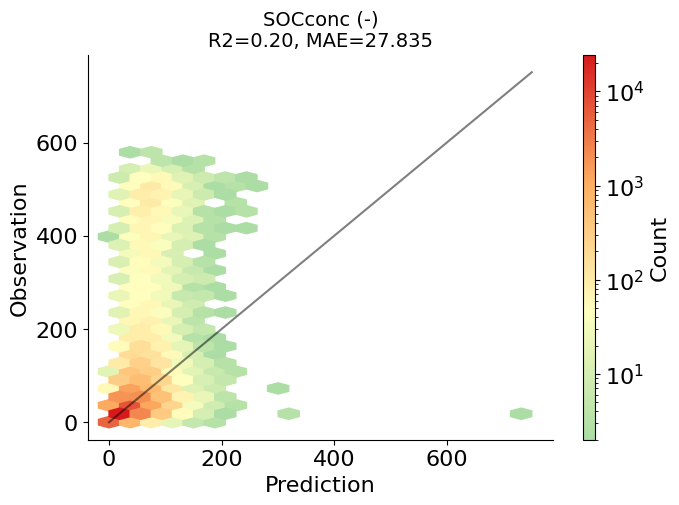

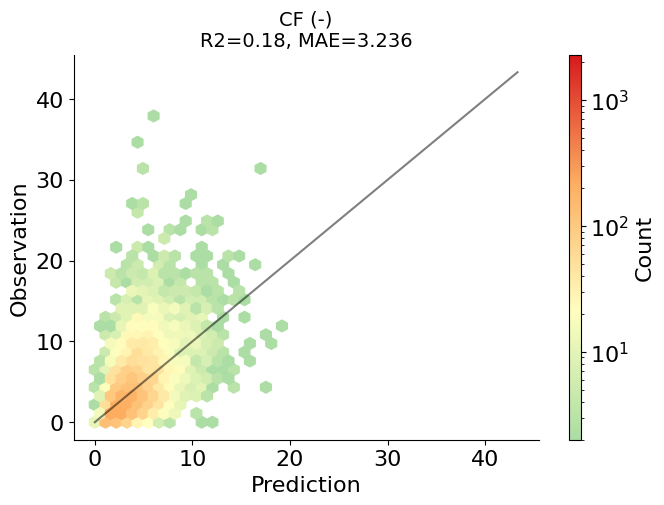

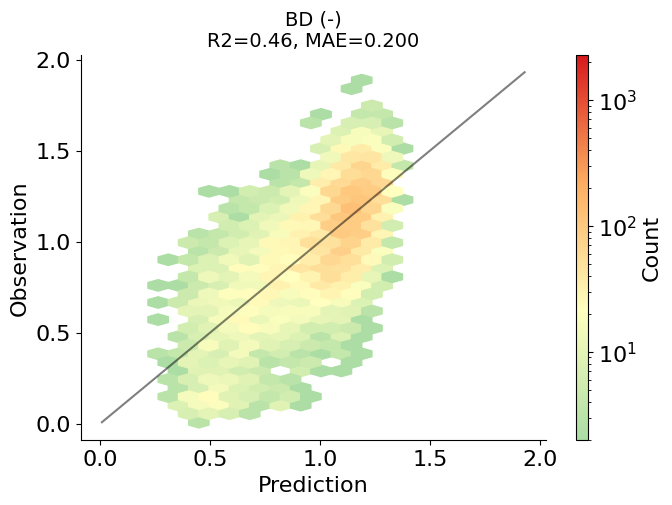

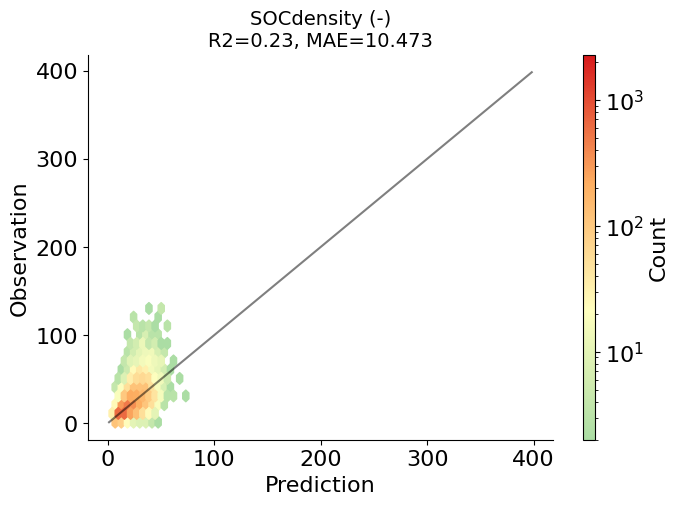

In [2]:
for tgt in target_names:
    y_all = df[tgt]
    yhat_all = df[f'pred_{tgt}']
    
    accuracy_plot(y_all, yhat_all, tgt)
    

## How well the model reconstruct relationship between SOCconc and BD
- Cramér–von Mises distance (CvM): the global squared difference between the entire copula surfaces
- Wasserstein distance (OT / Earth-Mover Distance) :minimum total transport cost required to rearrange the predicted point cloud into the true one

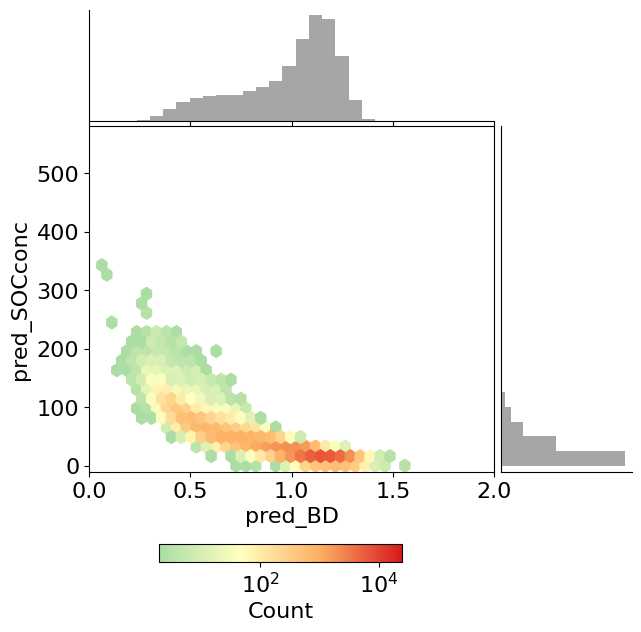

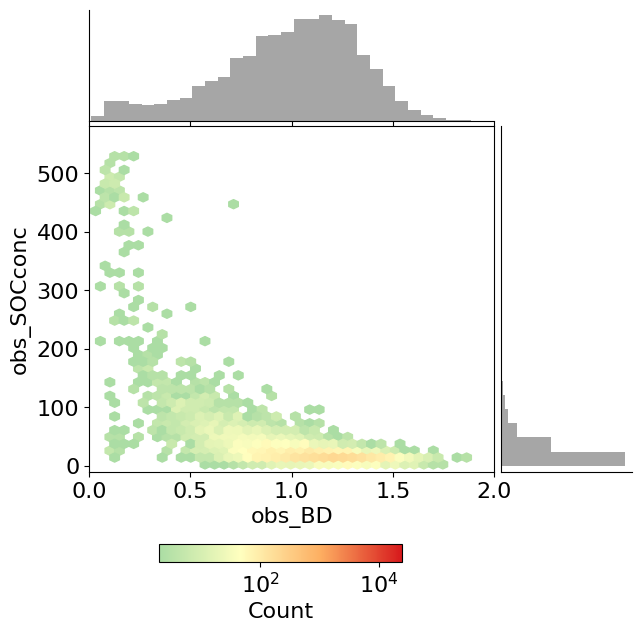

In [16]:

x = df['pred_BD']# / scalers.get('BD')
y = df['pred_SOCconc']# / scalers.get('SOCconc')) - 1
# relation_plot(x, y,'pred_BD', 'pred_SOCconc', [0,1], [0,1], save_plot=False)
relation_plot(x, y,'pred_BD', 'pred_SOCconc', [0,2], [-10,580], save_plot=False)



x = df['BD'] # / scalers.get('BD')
y = df['SOCconc'] #np.exp(df['SOCconc'] / scalers.get('SOCconc')) - 1
# relation_plot(x, y,'obs_BD', 'obs_SOCconc', [0,1], [0,1], save_plot=False)
relation_plot(x, y,'obs_BD', 'obs_SOCconc', [0,2], [-10,580], save_plot=False)

## explorative analysis of possible "outliers"

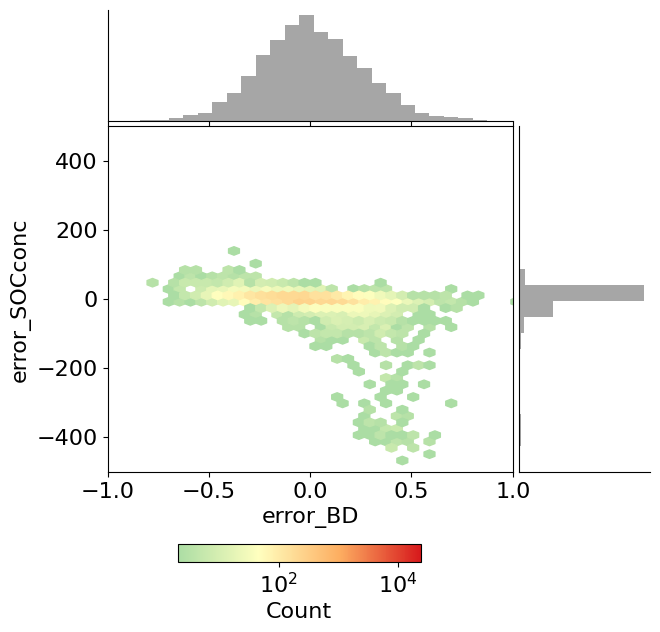

In [15]:
x = df['error_BD'] #/ scalers.get('BD')
y = df['error_SOCconc'] #/ scalers.get('SOCconc')
relation_plot(x, y,'error_BD', 'error_SOCconc', [-1,1], [-500,500], save_plot=False)

In [6]:
ab = df.loc[(df['error_BD']>0.2)&(df['error_SOCconc']<-0.3)]
print(len(ab), 'rows identified')

lc_column = ab["LC_group"]
counts = lc_column.value_counts()
print(counts)

# x = ab['BD'] # / scalers.get('BD')
# y = ab['SOCconc'] #np.exp(df['SOCconc'] / scalers.get('SOCconc')) - 1
# relation_plot(x, y,'obs_BD', 'obs_SOCconc', [0,2], [-10,580], save_plot=False)

973 rows identified
LC_group
woodland      454
cropland      254
grassland     198
shrubland      34
bareland       25
wetland         6
artificial      2
Name: count, dtype: int64


<Axes: >

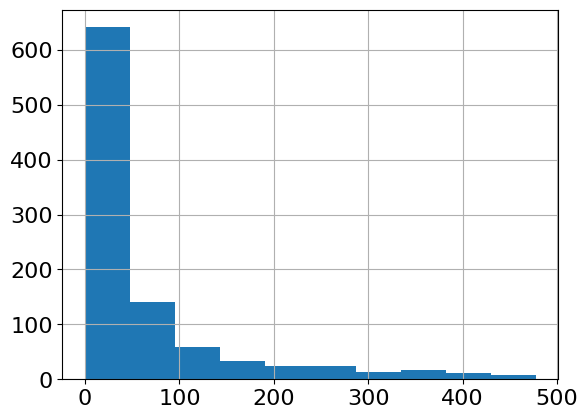

In [7]:
from itertools import combinations

def max_socconc_difference_for_id(group):
    """get the maximum absolute pairwise difference in SOCconc for each id"""
    values = group["SOCconc"].values
   
    # needs to be a series
    if len(values) < 2:
        return np.nan

    # compute pairwise absolute differences
    diffs = [
        abs(a - b) 
        for a, b in combinations(values, 2)
    ]

    return max(diffs)

# compute max differences for each id in df
id_to_maxdiff = (
    df.groupby("id")
      .apply(max_socconc_difference_for_id)
      .rename("max_SOCconc_diff")
)

ab = ab[ab.columns[0:394]].merge(id_to_maxdiff, on="id", how="left")
ab['max_SOCconc_diff'].hist(bins=10)

## land cover difference

SOCconc 61288 61288


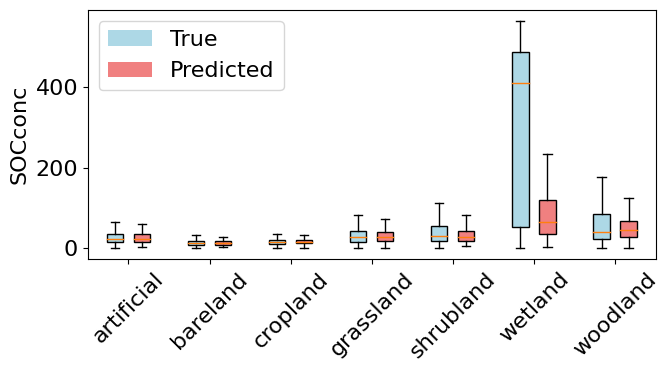

CF 5710 61288


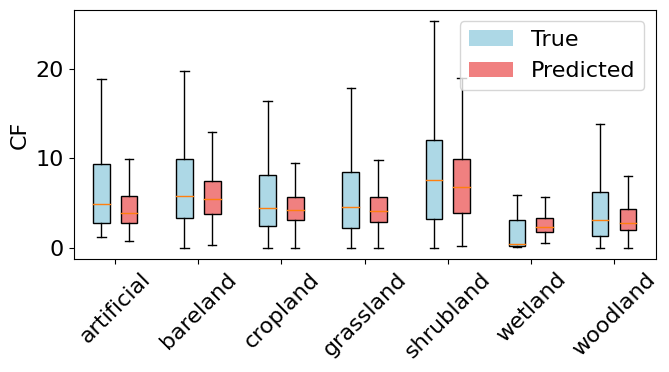

BD 5710 61288


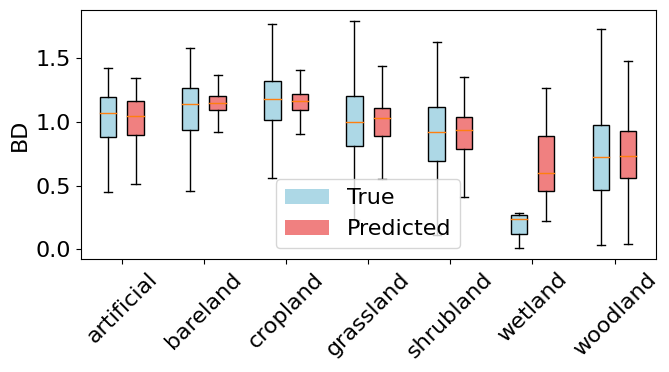

SOCdensity 5710 61288


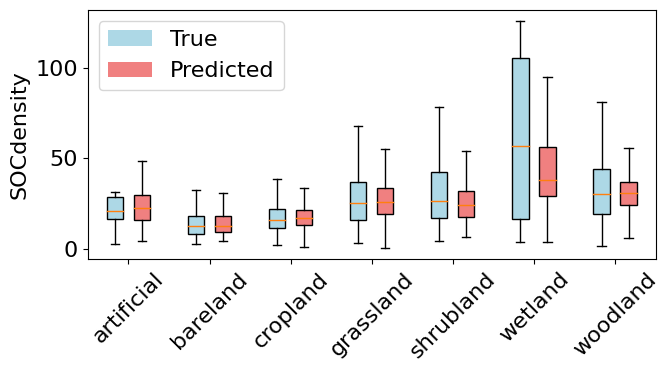

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch



target_names = ['SOCconc', 'CF', 'BD', 'SOCdensity']
land_covers = sorted([x for x in df['LC_group'].dropna().unique() if isinstance(x, str)])

colors = ['lightblue', 'lightcoral']  # True vs Pred colors
legend_labels = ['True', 'Predicted']

for target in target_names:
    pred_col = f'pred_{target}'
    print(target, df[target].notna().sum(), df[pred_col].notna().sum())
    
    plt.figure(figsize=(7, 4))
    
    positions = []
    data = []
    
    for i, lc in enumerate(land_covers):
        group = df[df['LC_group'] == lc]
        data.append(group[target].dropna())
        data.append(group[pred_col].dropna())
        
        # Position true at i*3 + 1, pred at i*3 + 2
        positions += [i * 3 + 1, i * 3 + 2]
    
    bp = plt.boxplot(data, positions=positions, widths=0.6, showfliers=False, patch_artist=True)
    
    # Color the boxes
    for j, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[j % 2])  # Alternate colors for true/pred
    
    # X-axis ticks: one per land cover
    x_tick_positions = [i * 3 + 1.5 for i in range(len(land_covers))]
    plt.xticks(x_tick_positions, land_covers, rotation=45)
    
    # plt.title(f'{target}: True vs Predicted by Land Cover')
    plt.ylabel(target)
    plt.xlim(0, len(land_covers) * 3)
    
    # Add legend
    legend_patches = [Patch(facecolor=colors[i], label=legend_labels[i]) for i in range(2)]
    plt.legend(handles=legend_patches)
    
    plt.tight_layout()
    plt.show()



## plausibility check: oBD and mBD

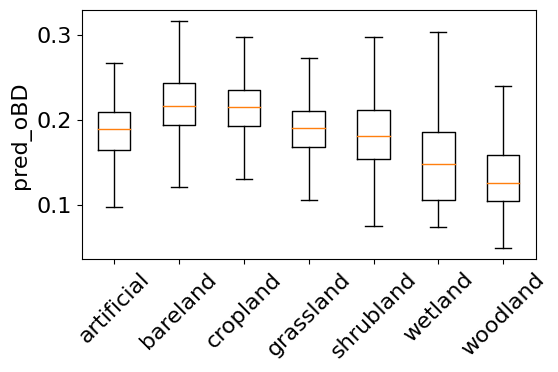

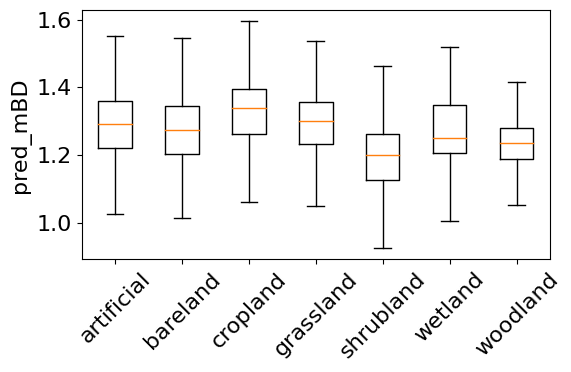

In [11]:
for target in ['pred_oBD','pred_mBD']:
    plt.figure(figsize=(6, 4))
    data = [df[df['LC_group'] == lc][target].dropna() for lc in land_covers]
    
    plt.boxplot(data, labels=land_covers, showfliers=False)
    # plt.title(f'{target} by Land Cover')
    plt.xticks(rotation=45)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

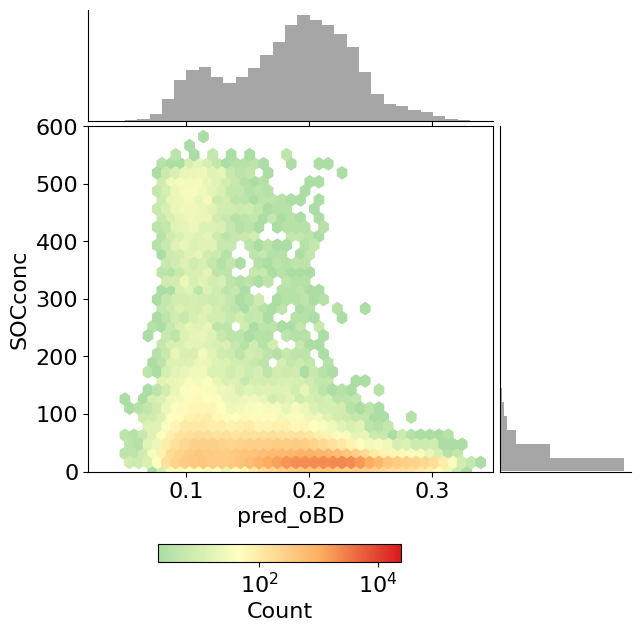

In [14]:
x = df['pred_oBD'] #/ scalers.get('BD')
y = df['SOCconc'] #/ scalers.get('SOCconc')
relation_plot(x, y,'pred_oBD', 'SOCconc', [0.02,0.35], [0,600], save_plot=False)

### temporal SOC realism
- Less fluctuations in SOCdensity predictions?
- Train model on lucas2018, whether hybrid performs better in predicting lucas2009 & 2015